In [34]:
interionic_spacing = .1
up_modifier = sqrt(3)/2 * interionic_spacing
over_modifer = 1/2 * interionic_spacing
points_inside_circle = []
digits = 2
radius = .5
function gen_points(pt, points_inside_circle, x, y)
    pt = [round(pt[1], digits=digits), round(pt[2], digits=digits)]
    if pt in points_inside_circle || pt[1]^2 + pt[2]^2 > radius^2
        return
    else
        push!(points_inside_circle, pt)
        push!(x, pt[1])
        push!(y, pt[2])
        gen_points([pt[1] + over_modifer, pt[2] - up_modifier], points_inside_circle, x, y)
        gen_points([pt[1] - over_modifer, pt[2] - up_modifier], points_inside_circle, x, y)
        gen_points([pt[1] - over_modifer, pt[2] + up_modifier], points_inside_circle, x, y)
        gen_points([pt[1] + over_modifer, pt[2] + up_modifier], points_inside_circle, x, y)
        gen_points([pt[1] + interionic_spacing, pt[2]], points_inside_circle, x, y)
        gen_points([pt[1] + interionic_spacing, pt[2]], points_inside_circle, x, y)
        gen_points([pt[1] - interionic_spacing, pt[2]], points_inside_circle, x, y)
        return points_inside_circle, x, y
    end
end
pairs, x, y = gen_points([0, 0], [], [], [])
function circleShape(h, k, r)
    θ = LinRange(0, 2*π, 500)
    h .+ r*sin.(θ), k .+ r*cos.(θ)
end
using Plots
gr() # We will continue onward using the GR backend
plot(x, y, seriestype = :scatter, title = "Top View of Penning Trap")
plot!(circleShape(0, 0, .5), seriestype = [:shape,], lw = .5, c=:blue, lincolor = :black, legend=false, fillalpha=.2, aspect_ratio = 1, axis=nothing, border=:none)
num_points = 500
rs = LinRange(0, 1, num_points)
θs = LinRange(0, 2π, num_points)
pairs = [(r, θ) for r in rs for θ in θs]
xs = [pair[1] * cos(pair[2]) for pair in pairs]
ys = [pair[1] * sin(pair[2]) for pair in pairs]
xs = LinRange(-1, 1, num_points)
ys = LinRange(-1, 1, num_points)

500-element LinRange{Float64}:
 -1.0,-0.995992,-0.991984,-0.987976,-0.983968,…,0.987976,0.991984,0.995992,1.0

In [36]:
using Cubature
function R(n::Int64, m::Int64, ρ::Float64)
    if (n - m) % 2 != 0
        0
    else
        function summand(k)
            n = big(n)
            k = big(k)
            (-1)^k * factorial(n-k)/(factorial(k)*factorial(Int((n+m)/2) - k)*factorial(Int((n-m)/2) - k))*(ρ)^(n-2*k)
        end
        mapreduce(summand, +, Array(range(0, stop=Int((n-m)/2), step=1)))
    end
end

function Z(n, m, ρ, θ)
    if m < 0
        R(n, abs(m), ρ) * sin(abs(m) * θ)
    else
        R(n, m, ρ) * cos(m * θ)
    end
end
σ1 = 1
σ2 = .1
displacement = 0
function integrand(n, m)
    function rtn(coor)
        ρ = coor[1]
        θ = coor[2]
        x = ρ * cos(θ) + displacement
        y = ρ * sin(θ)
        Z(n, m, ρ, θ) * exp(-x^2/σ1^2 - y^2/σ2^2) * ρ
    end
    rtn
end
function neumann(m)
    if m == 0
        2
    else 
        1
    end
end
function cond_eval(n, m)
    if -n ≤ m ≤ n
        (2*n+2)/(π*neumann(m)) * hcubature(integrand(n, m), [0., 0.], [1., 2*π], maxevals=10000)[1]
    else
        0
    end
end
using Plots
gr()
#maxm = 15
#maxn = 32
maxm = 12
maxn = 32
data = hcat([[c[1] for c in [cond_eval(n, m) for n in range(0, maxn, step=1)]] for m in range(0, maxm, step=1)]...)

33×13 Array{Real,2}:
  0.0841651    0             0          …   0             0
  0.0         -6.59919e-17   0              0             0
 -0.122324     0.0           0.125134       0             0
  0.0          5.44932e-17   0.0            0             0
  0.112798     0.0          -0.177494       0             0
  0.0          1.3713e-16    0.0        …   0             0
 -0.102954     0.0           0.185564       0             0
  0.0          1.65473e-17   0.0            0             0
  0.0938746    0.0          -0.177343       0             0
  0.0          2.33078e-10   0.0            0             0
 -0.084471     0.0           0.162887   …   0             0
  0.0          8.11704e-17   0.0            7.67817e-14   0
  0.07469      0.0          -0.145613       0.0           0.0620081
  ⋮                                     ⋱                
  0.0         -2.57171e-17   0.0            5.58995e-13   0.0
 -0.0302538    0.0           0.0600355      0.0          -0.0455573
  0

In [37]:
# using Plots
# heatmap(data, xlabel="m", ylabel="n", title="Zernike Coefficient")

In [38]:
# data2 = data[1:end-30, 1:end-25]
# using Plots
# heatmap(data2, xlabel="m", ylabel="n", title="Zernike Coefficient")

In [39]:
function recon(ρ, ϕ)
    total = 0
    for (n,x) in enumerate(eachrow(data))
        for (m,y) in enumerate(x)
            if m ≤ n
                total += y*Z(n-1, m-1, ρ, ϕ)
            end
        end
    end
    total
end


recon (generic function with 1 method)

In [40]:
# a = range(0, stop=.5,step=.001)
# b = [recon(aa,π) - gaussian(aa, π) for aa in a]
# plot(a, b, xlabel="x coordinate", ylabel="recon-gaussian error")

In [41]:
function sample_across_unit_disk(f, discretization)
    x = y = Array(range(-1, 1, length=discretization))
    z = Array{typeof(f(0.,0.))}(UndefInitializer(), length(x), length(y))
    for (i, xx) in enumerate(x)
        for (j, yy) in enumerate(y)
            if xx^2 + yy^2 > 1
                if typeof(f(0.,0.)) == Tuple{Float64,Float64}
                    z[i, j] = (0.,0.)
                else
                    z[i, j] = 0.
                end
            else
                ρ = sqrt(xx^2 + yy^2)
                ϕ = atan(yy, xx)
                res = f(ρ, ϕ)
                z[i, j] = res
            end
        end
    end
    x, y, z
end


sample_across_unit_disk (generic function with 1 method)

In [42]:
function gaussian(ρ, θ)
    x = ρ*cos(θ)
    y = ρ*sin(θ)
    exp(-x^2/σ1^2-y^2/σ2^2)
end

gaussian (generic function with 1 method)

In [21]:
times = []
nums = [5, 10, 50, 100]
for num in nums
    start = time()
    xx, yy, samples =  sample_across_unit_disk(recon, num)
    stop = time()
    push!(times, stop-start)
end

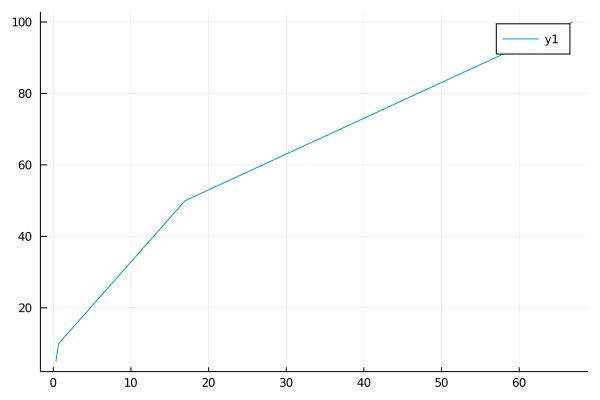

In [22]:
plot(times, nums)

In [24]:
start = time()
num_points = 500
xx, yy, samples =  sample_across_unit_disk(recon, num_points);
stop = time()
print(stop-start)

1690.5163731575012

In [25]:
xx, yy, samples2 =  sample_across_unit_disk(gaussian, num_points)

([-1.0, -0.9959919839679359, -0.9919839679358717, -0.9879759519038076, -0.9839679358717435, -0.9799599198396793, -0.9759519038076152, -0.9719438877755511, -0.9679358717434869, -0.9639278557114228  …  0.9639278557114228, 0.9679358717434869, 0.9719438877755511, 0.9759519038076152, 0.9799599198396793, 0.9839679358717435, 0.9879759519038076, 0.9919839679358717, 0.9959919839679359, 1.0], [-1.0, -0.9959919839679359, -0.9919839679358717, -0.9879759519038076, -0.9839679358717435, -0.9799599198396793, -0.9759519038076152, -0.9719438877755511, -0.9679358717434869, -0.9639278557114228  …  0.9639278557114228, 0.9679358717434869, 0.9719438877755511, 0.9759519038076152, 0.9799599198396793, 0.9839679358717435, 0.9879759519038076, 0.9919839679358717, 0.9959919839679359, 1.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

In [26]:
# a = abs.((samples-samples2))


In [27]:
# a = samples
# b = samples2

In [28]:
# b = b[b.<100]

In [29]:
# a = abs.(samples-samples2)

In [30]:
# a = a[a.<1000]

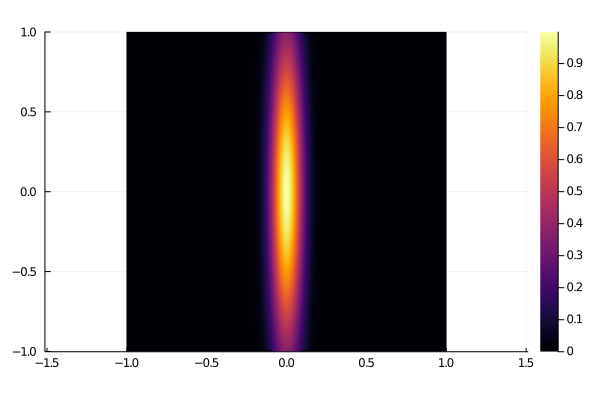

In [31]:
plot(heatmap(xx, yy, samples2), cm=:ice, aspectratio=true)

In [32]:
yy

500-element Array{Float64,1}:
 -1.0
 -0.9959919839679359
 -0.9919839679358717
 -0.9879759519038076
 -0.9839679358717435
 -0.9799599198396793
 -0.9759519038076152
 -0.9719438877755511
 -0.9679358717434869
 -0.9639278557114228
 -0.9599198396793587
 -0.9559118236472945
 -0.9519038076152304
  ⋮
  0.9559118236472945
  0.9599198396793587
  0.9639278557114228
  0.9679358717434869
  0.9719438877755511
  0.9759519038076152
  0.9799599198396793
  0.9839679358717435
  0.9879759519038076
  0.9919839679358717
  0.9959919839679359
  1.0

┌ Warning: Multiple series with different color share a colorbar. Colorbar may not reflect all series correctly.
└ @ Plots /home/ampolloreno/.julia/packages/Plots/oZheM/src/backends/gr.jl:498
┌ Warning: Multiple series with different fill alpha share a colorbar. Colorbar may not reflect all series correctly.
└ @ Plots /home/ampolloreno/.julia/packages/Plots/oZheM/src/backends/gr.jl:498


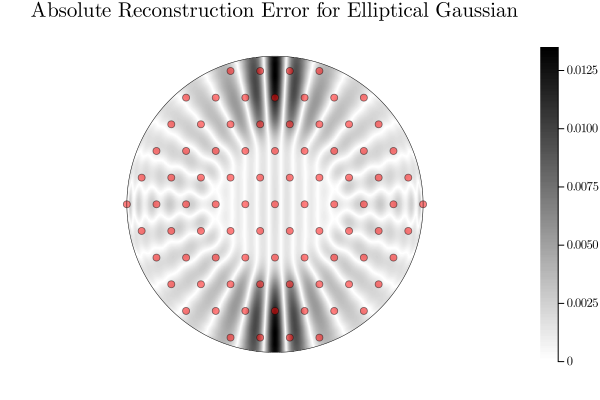

In [33]:
using LaTeXStrings
amp = .1
max = maximum(amp*abs.(samples-samples2))
p = palette([:white, :black], 100)
plot(heatmap(xx, yy, amp*abs.(samples-samples2), c=p),aspectratio=true, legend=false, aspect_ratio = 1, axis=nothing, border=:none, title=L"\textrm{Absolute Reconstruction Error for Elliptical Gaussian}", fontfamily="Computer Modern")
p = palette([:white, :red], 100)
scatter!(x/radius, y/radius, marker_z = [max for _ in x], c=p, alpha=.5)
p = palette([:white, :black], 100)
scatter!(x/radius, y/radius, marker_z = [max for _ in x], c=p, alpha=0)
plot!(circleShape(0, 0, 1), seriestype = [:shape,], lw = .5, c=:blue, lincolor = :black, legend=false, fillalpha=0, aspect_ratio = 1, axis=nothing, border=:none, fontfamily="Computer Modern")

In [37]:
using SpecialFunctions
using QuantumOptics

function fidelity(ρ, σ)
    tr(sqrt(sqrt(ρ) * σ * sqrt(ρ)))^(1/2)
end

function R(n::Int64, m::Int64, ρ::Float64)
    if (n - m) % 2 != 0
        0
    else
        function summand(k)
            n = big(n)
            k = big(k)
            (-1)^k * factorial(n-k)/(factorial(k)*factorial(Int((n+m)/2) - k)*factorial(Int((n-m)/2) - k))*(ρ)^(n-2*k)
        end
        mapreduce(summand, +, Array(range(0, stop=Int((n-m)/2), step=1)))
    end
end

function sample_across_unit_disk(f, discretization)
    x = y = Array(range(-1, 1, length=discretization))
    z = Array{typeof(f(0.,0.))}(UndefInitializer(), length(x), length(y))
    for (i, xx) in enumerate(x)
        for (j, yy) in enumerate(y)
            if xx^2 + yy^2 > 1
                if typeof(f(0.,0.)) == Tuple{Float64,Float64}
                    z[i, j] = (0.,0.)
                else
                    z[i, j] = 0.
                end
            else
                ρ = sqrt(xx^2 + yy^2)
                ϕ = atan(yy, xx)
                res = f(ρ, ϕ)
                z[i, j] = res
            end
        end
    end
    x, y, z
end

function unpack_zernike(zernike_coefficients_even, zernike_coefficients_odd, ρ, ω, t)
    """Each Zernike array is of arbitrary length, but they are ordered by order. The first is Z00 to Zn0 where
    n is the number of 0th order zernike polynomials being considered."""
    Pevens = []
    eventuples = []
    for (n, zeven) in enumerate(zernike_coefficients_even)
        neven = n - 1
        push!(Pevens, [zeven[i] * R(neven, i-1, ρ) for i in Array(range(1, length(zeven), step=1))])
    end
    for i in range(1, length(Pevens), step=1)
        rotationeven = - (i - 1) * ω * t
        total = 0
        for peven in Pevens
            if length(peven) >= i
                total += peven[i]
            end
        end    
        push!(eventuples, (i - 1, total, rotationeven))
    end

    Podds = []
    oddtuples = []
    for (n, zodd) in enumerate(zernike_coefficients_odd)
        nodd = n - 1
        push!(Podds, [zodd[i] * R(nodd, i-1, ρ) for i in Array(range(1, length(zodd), step=1))])
    end
    for i in range(1, length(Podds), step=1)
        rotationodd = - (i - 1) * ω * t
        total = 0
        for podd in Podds
            if length(podd) >= i
                total += podd[i]
            end
        end    
        push!(oddtuples, (i - 1, total, rotationodd))
    end
    eventuples, oddtuples
end

function infidelity_across_disk(F1, F2)
    function infidelity_polar(ρ, ϕ)
        ψ1 = F1(ρ, ϕ).data
        ψ2 = F2(ρ, ϕ).data
        1 - real(fidelity(ψ1, ψ2))
    end
end

function H_odf(ρ, ϕ, t, zernike_recon, U, ψ, ω, orders)
    total = 0
    amp = .1
    for order in orders
        total += U/amp * cos(-order*ω*t + ψ + amp*zernike_recon(ρ, ϕ)) 
    end
    total
end

toarray(s::Union{Set, Array}) = [toarray.(s)...]
toarray(v::Number) = v

toarray (generic function with 2 methods)

In [14]:
σ1 = .1
σ2 = 1
function gaussian(σ1, σ2)
    function func(ρ, ϕ)
        x = ρ*cos(ϕ)
        y = ρ*sin(ϕ)
        exp(-x^2/σ1^2 + -y^2/σ2^2)
    end
end

gaussian (generic function with 1 method)

In [15]:
function simultaneous_exact_evolution_evaluator_factory(ψ0, T, zernike_recon, U, θ, ω, b, maxm)
    """Apply all the zernike coefficients given, in order, for time T each."""
    orders = range(0, maxm, step=1)
    function evaluator(ρ, ϕ)
        H(t, _) = H_odf(ρ, ϕ, t, zernike_recon, U, θ, ω, orders)*sigmaz(b), [], []
        _, ψ = @skiptimechecks timeevolution.master_dynamic(T, ψ0, H)
        last(ψ)
    end
end

function gaussian_spin_profile(ρ, ϕ)
    ψ0 = 1/sqrt(2) * (spindown(b) + spinup(b))
    H(t, _) = gaussian(σ1, σ2)(ρ, ϕ) * sigmaz(b), [], []
    evolution_time = π/2
    step_size = evolution_time/1
    T = [0.0:step_size:evolution_time;];
    _, ψ = timeevolution.master_dynamic(T, ψ0, H)
    last(ψ)
end

gaussian_spin_profile (generic function with 1 method)

In [16]:
Γ = 1/62
ω = 2*π*180E3
θ = -π/2;
b = SpinBasis(1//2)
ψ0 = 1/sqrt(2) * (spindown(b) + spinup(b))
evolution_time =  50E-6
U = π/(evolution_time)
step_size = evolution_time
T = [0.0:step_size:evolution_time;];
simultaneous_exact_evolution = simultaneous_exact_evolution_evaluator_factory(ψ0, T, recon, U, θ, ω, b, 10)

(::var"#evaluator#16"{Ket{SpinBasis{1//2,Int64},Array{Complex{Float64},1}},Array{Float64,1},typeof(recon),Float64,Float64,Float64,SpinBasis{1//2,Int64},StepRange{Int64,Int64}}) (generic function with 1 method)

In [17]:
function infidelity_across_disk(F1, F2)
    function infidelity_polar(ρ, ϕ)
        ψ1 = F1(ρ, ϕ).data
        ψ2 = F2(ρ, ϕ).data
        1 - real(fidelity(ψ1, ψ2))
    end
end

infidelity_across_disk (generic function with 1 method)

In [18]:
function plot_triangles_across_unit_disk(f, x, y)
    ret = []
    for (i, xx) in enumerate(x)
        print(i)
        ρ = sqrt(xx^2 + y[i]^2)
        ϕ = atan(y[i], xx)
        res = f(ρ, ϕ)
        push!(ret, res)
        end
    ret
end

plot_triangles_across_unit_disk (generic function with 1 method)

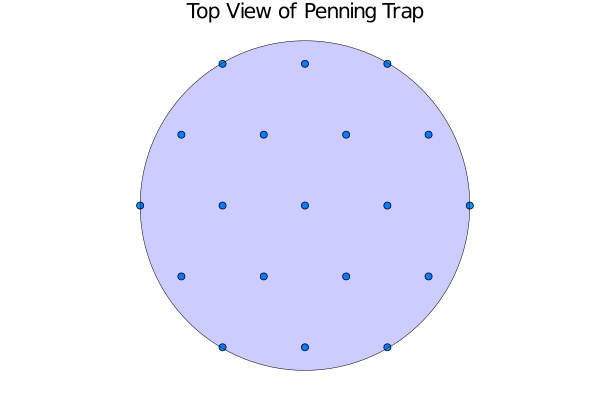

In [19]:
interionic_spacing = .5
up_modifier = sqrt(3)/2 * interionic_spacing
over_modifer = 1/2 * interionic_spacing
points_inside_circle = []
digits = 2
function gen_points(pt, points_inside_circle, x, y)
    pt = [round(pt[1], digits=digits), round(pt[2], digits=digits)]
    if pt in points_inside_circle || pt[1]^2 + pt[2]^2 > 1
        return
    else
        push!(points_inside_circle, pt)
        push!(x, pt[1])
        push!(y, pt[2])
        gen_points([pt[1] + over_modifer, pt[2] - up_modifier], points_inside_circle, x, y)
        gen_points([pt[1] - over_modifer, pt[2] - up_modifier], points_inside_circle, x, y)
        gen_points([pt[1] - over_modifer, pt[2] + up_modifier], points_inside_circle, x, y)
        gen_points([pt[1] + over_modifer, pt[2] + up_modifier], points_inside_circle, x, y)
        gen_points([pt[1] + interionic_spacing, pt[2]], points_inside_circle, x, y)
        gen_points([pt[1] + interionic_spacing, pt[2]], points_inside_circle, x, y)
        gen_points([pt[1] - interionic_spacing, pt[2]], points_inside_circle, x, y)
        return points_inside_circle, x, y
    end
end
pairs, x, y = gen_points([0, 0], [], [], [])
function circleShape(h, k, r)
    θ = LinRange(0, 2*π, 500)
    h .+ r*sin.(θ), k .+ r*cos.(θ)
end
using Plots
gr() # We will continue onward using the GR backend
plot(x, y, seriestype = :scatter, title = "Top View of Penning Trap")
plot!(circleShape(0, 0, 1), seriestype = [:shape,], lw = .5, c=:blue, lincolor = :black, legend=false, fillalpha=.2, aspect_ratio = 1, axis=nothing, border=:none)

In [21]:
start = time()
z = plot_triangles_across_unit_disk(infidelity_across_disk(gaussian_spin_profile, simultaneous_exact_evolution), x, y)
stop = time()

123

LoadError: InterruptException:

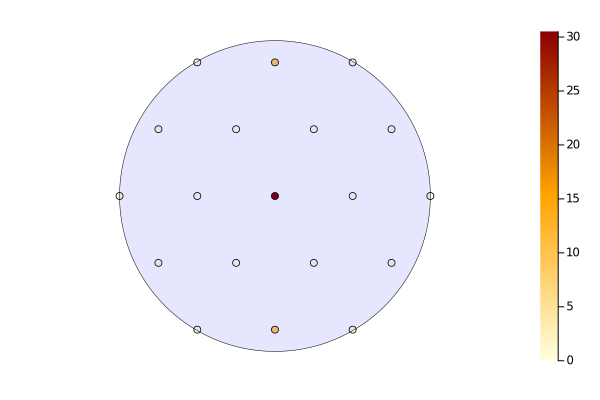

In [205]:
using Plots
#plot(x, y, seriestype = :scatter, title = "Top View of Penning Trap")
scatter(x, y, marker_z = 100*z,  c = :heat)
plot!(circleShape(0, 0, 1), seriestype = [:shape,], lw = .5, c=:blue, lincolor = :black, legend=false, fillalpha=.1, aspect_ratio = 1, axis=nothing, border=:none)


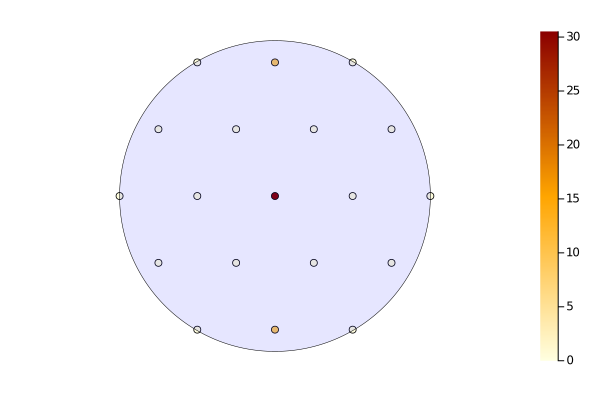

In [196]:
using Plots
#plot(x, y, seriestype = :scatter, title = "Top View of Penning Trap")
scatter(x, y, marker_z = 100*z,  c = :heat)
plot!(circleShape(0, 0, 1), seriestype = [:shape,], lw = .5, c=:blue, lincolor = :black, legend=false, fillalpha=.1, aspect_ratio = 1, axis=nothing, border=:none)
